The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [ ]:
# TODO : import the dataset
df = pd.read_csv('/content/AB_Test_Results.csv')

In [ ]:
# TODO : take a quick look at the data
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user
unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
print(unique_groups_per_user.value_counts())


VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


In [ ]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
unique_groups_per_user.describe()

,VARIANT_NAME
count,6324.000000
mean,1.243675
std,0.429333
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


What can you observe ? Should we exclude these users ? Why ?

In [ ]:
# TODO : users have 1 A/B test group ?

# Calculate the number of unique groups for each user
unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

# Filter for users with only one group
print(unique_groups_per_user.value_counts())

# TODO : Take only these users


VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


In [ ]:
# TODO : Leave only records with users with the 1st ab test group
single_group_users = df[df['USER_ID'].isin(unique_groups_per_user[unique_groups_per_user == 1].index)]

# TODO : Check that the number of users matches what it was before the exception
print(single_group_users.info())


<class 'pandas.core.frame.DataFrame'>
Index: 6070 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       6070 non-null   int64  
 1   VARIANT_NAME  6070 non-null   object 
 2   REVENUE       6070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 189.7+ KB
None


Let's see how the data is distributed

<ipython-input-40-be37d2b95f51>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=single_group_users, palette='Set2', saturation=0.75)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pas

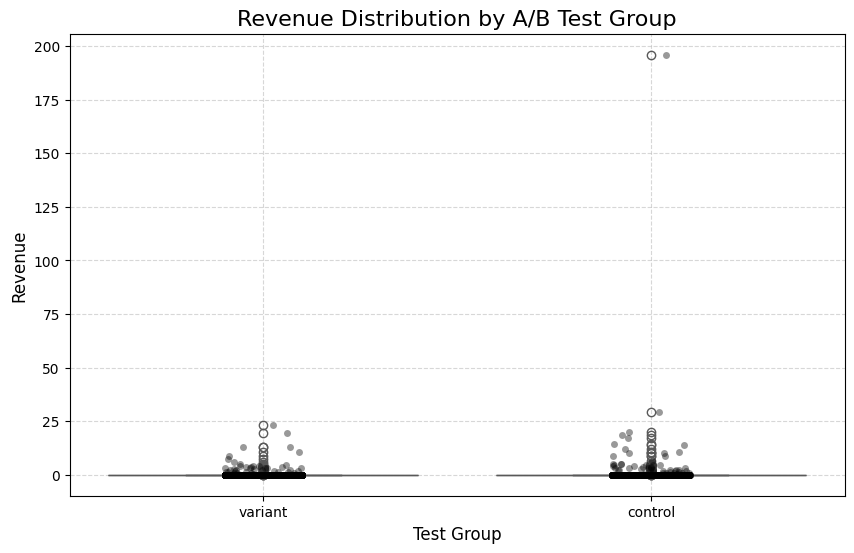

In [ ]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=single_group_users, palette='Set2', saturation=0.75)
sns.stripplot(x='VARIANT_NAME', y='REVENUE', data=single_group_users, jitter=True, color='black', alpha=0.4)
plt.title('Revenue Distribution by A/B Test Group', fontsize=16)
plt.xlabel('Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [ ]:
# TODO : Sort these revenue values in descending order
sorted_revenue = single_group_users.sort_values(by='REVENUE', ascending=False)


In [ ]:
# TODO : See if user 3342 had other events with a strong outlier
cleaned_data = single_group_users[single_group_users['USER_ID'] != 3342]


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<ipython-input-44-45ea865d2177>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=cleaned_data, palette='coolwarm', saturation=0.75)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass 

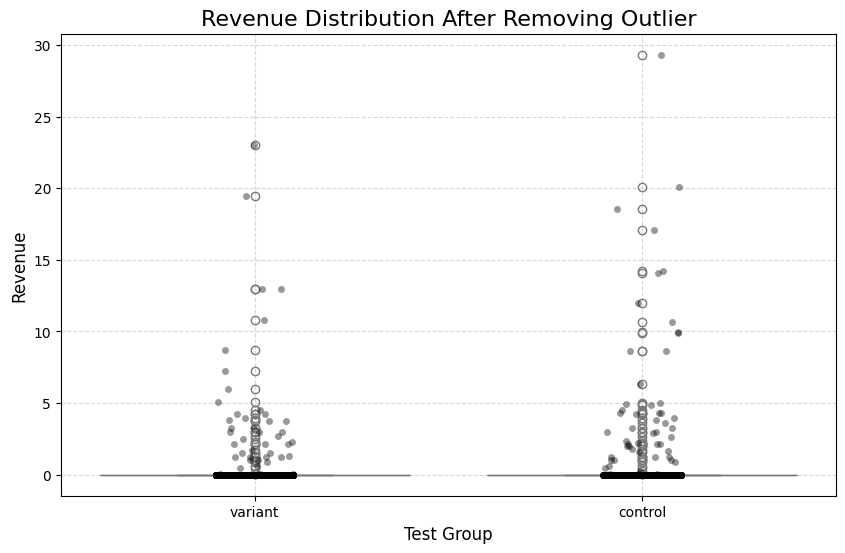

In [ ]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=cleaned_data, palette='coolwarm', saturation=0.75)
sns.stripplot(x='VARIANT_NAME', y='REVENUE', data=cleaned_data, jitter=True, color='black', alpha=0.4)
plt.title('Revenue Distribution After Removing Outlier', fontsize=16)
plt.xlabel('Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



What can you say about the users and their purchases ?

In [ ]:
# TODO : Check if there are users who have records with zero and positive revenue


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [ ]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
user_grouped = cleaned_data.groupby(['USER_ID', 'VARIANT_NAME']).agg({'REVENUE': 'sum'}).reset_index()


<ipython-input-47-c098403d34e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='VARIANT_NAME', y='REVENUE', data=user_grouped, inner="quartile", palette='Set1', saturation=0.75)


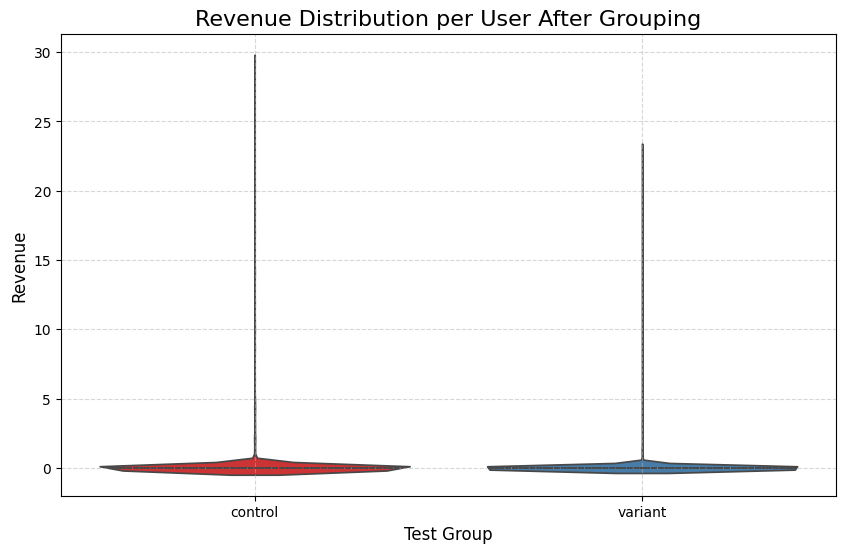

In [ ]:
# TODO : Visualize the resulting distribution of the data again.
plt.figure(figsize=(10, 6))
sns.violinplot(x='VARIANT_NAME', y='REVENUE', data=user_grouped, inner="quartile", palette='Set1', saturation=0.75)
plt.title('Revenue Distribution per User After Grouping', fontsize=16)
plt.xlabel('Test Group', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [ ]:
# TODO : get metrics by groups
group_metrics = user_grouped.groupby('VARIANT_NAME').agg(
    total_revenue=('REVENUE', 'sum'),

# TODO : create two additional metrics to see relative changes
 avg_revenue_per_user=('REVENUE', 'mean'),
    user_count=('USER_ID', 'count')
).reset_index()
# TODO : add them to the rest of the metrics in a separate group
print(group_metrics)


  VARIANT_NAME  total_revenue  avg_revenue_per_user  user_count
0      control         274.55              0.114923        2389
1      variant         179.32              0.074935        2393


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups
group_metrics = user_grouped.groupby('VARIANT_NAME').agg(
    total_revenue=('REVENUE', 'sum'),
    avg_revenue_per_user=('REVENUE', 'mean'),
    user_count=('USER_ID', 'count')
).reset_index()

print(group_metrics)


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group


  VARIANT_NAME  total_revenue  avg_revenue_per_user  user_count
0      control         274.55              0.114923        2389
1      variant         179.32              0.074935        2393


Let's look at the distributions of all and only paying users

In [ ]:
group_metrics['avg_revenue_per_user_pct_change'] = group_metrics['avg_revenue_per_user'].pct_change() * 100
group_metrics['total_revenue_pct_change'] = group_metrics['total_revenue'].pct_change() * 100

print(group_metrics)


  VARIANT_NAME  total_revenue  avg_revenue_per_user  user_count  \
0      control         274.55              0.114923        2389   
1      variant         179.32              0.074935        2393   

   avg_revenue_per_user_pct_change  total_revenue_pct_change  
0                              NaN                       NaN  
1                       -34.795025                 -34.68585  


<ipython-input-54-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-54-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

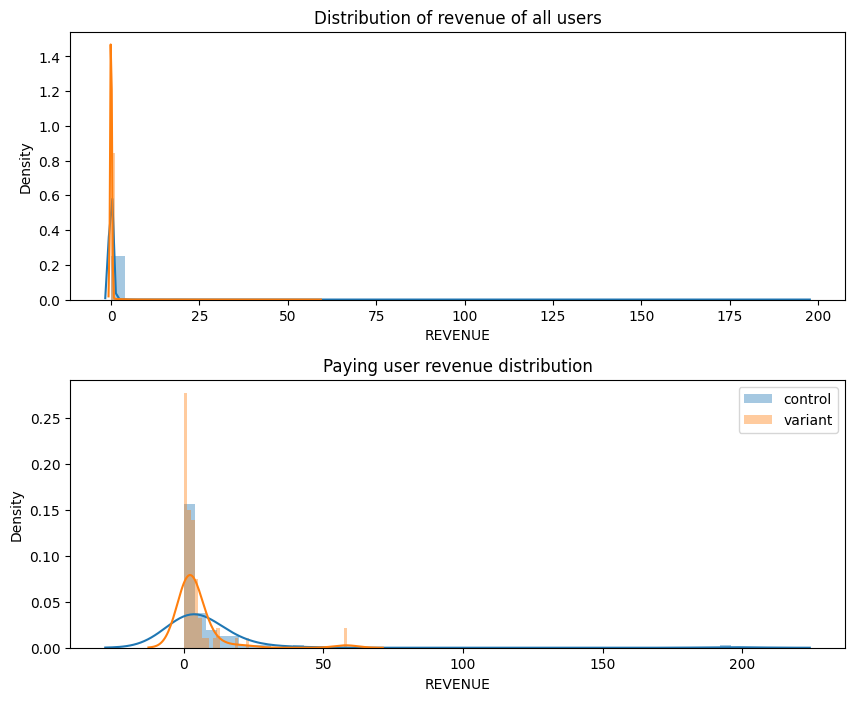

In [ ]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
# Shapiro-Wilk test for normality for all users
shapiro_control_all = shapiro(df[df['VARIANT_NAME'] == 'control']['REVENUE'])
shapiro_variant_all = shapiro(df[df['VARIANT_NAME'] == 'variant']['REVENUE'])

# Shapiro-Wilk test for normality for paying users only
shapiro_control_paying = shapiro(df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0)]['REVENUE'])
shapiro_variant_paying = shapiro(df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0)]['REVENUE'])

# Print Shapiro-Wilk test results
print("Shapiro-Wilk Test (Control - All Users):", shapiro_control_all)
print("Shapiro-Wilk Test (Variant - All Users):", shapiro_variant_all)
print("Shapiro-Wilk Test (Control - Paying Users):", shapiro_control_paying)
print("Shapiro-Wilk Test (Variant - Paying Users):", shapiro_variant_paying)


Shapiro-Wilk Test (Control - All Users): ShapiroResult(statistic=0.01833147442513483, pvalue=2.4983285100057203e-95)
Shapiro-Wilk Test (Variant - All Users): ShapiroResult(statistic=0.027033073451830147, pvalue=2.7310104028899288e-95)
Shapiro-Wilk Test (Control - Paying Users): ShapiroResult(statistic=0.28080554615611364, pvalue=6.50334178109615e-18)
Shapiro-Wilk Test (Variant - Paying Users): ShapiroResult(statistic=0.4170522102926101, pvalue=2.114043206787204e-15)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
mannwhitney_all = mannwhitneyu(df[df['VARIANT_NAME'] == 'control']['REVENUE'],
                               df[df['VARIANT_NAME'] == 'variant']['REVENUE'])
print(mannwhitney_all)

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
mannwhitney_paying = mannwhitneyu(df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0)]['REVENUE'],
                                  df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0)]['REVENUE'])
print(mannwhitney_paying)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users
control_revenue_all = df[df['VARIANT_NAME'] == 'control']['REVENUE'].values
variant_revenue_all = df[df['VARIANT_NAME'] == 'variant']['REVENUE'].values

control_bootstrap_all = get_bootstrap_samples(control_revenue_all, n_samples=1000)
variant_bootstrap_all = get_bootstrap_samples(variant_revenue_all, n_samples=1000)


In [ ]:
# TODO : Generate samples for only paying users
control_revenue_paying = df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0)]['REVENUE'].values
variant_revenue_paying = df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0)]['REVENUE'].values

control_bootstrap_paying = get_bootstrap_samples(control_revenue_paying, n_samples=1000)
variant_bootstrap_paying = get_bootstrap_samples(variant_revenue_paying, n_samples=1000)


Let's look at the distribution of means in the ab test groups

<ipython-input-63-46f2a87159b7>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_bootstrap_all, axis=1), shade=True, label='Control - All Users', color='skyblue')
<ipython-input-63-46f2a87159b7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_bootstrap_all, axis=1), shade=True, label='Variant - All Users', color='orange')


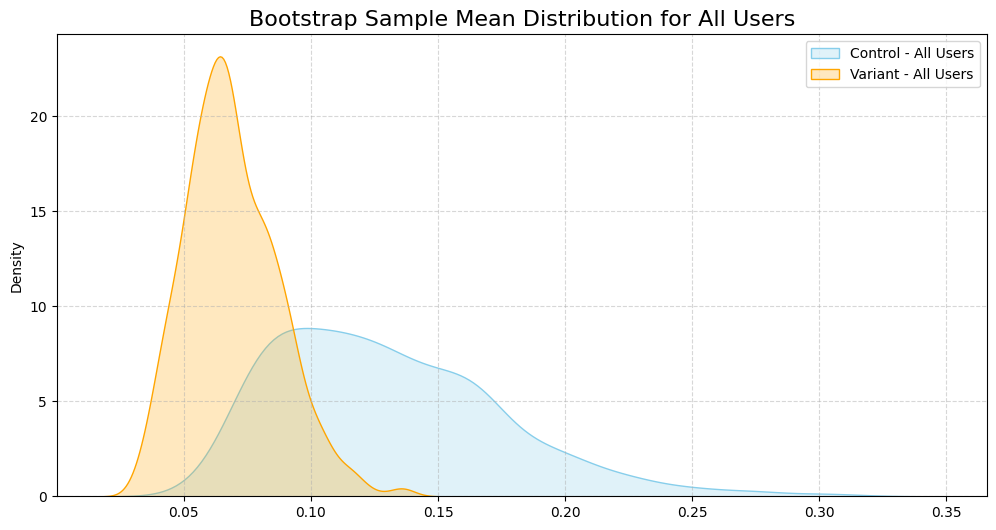

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(np.mean(control_bootstrap_all, axis=1), shade=True, label='Control - All Users', color='skyblue')
sns.kdeplot(np.mean(variant_bootstrap_all, axis=1), shade=True, label='Variant - All Users', color='orange')
plt.title('Bootstrap Sample Mean Distribution for All Users', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



<ipython-input-64-7cca7655871e>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_bootstrap_paying, axis=1), shade=True, label='Control - Paying Users', color='skyblue')
<ipython-input-64-7cca7655871e>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_bootstrap_paying, axis=1), shade=True, label='Variant - Paying Users', color='orange')


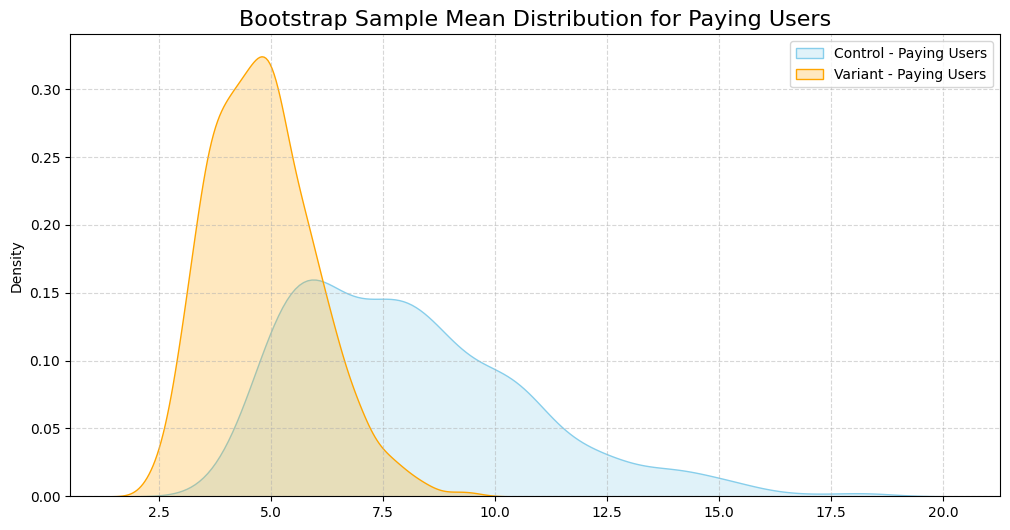

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(np.mean(control_bootstrap_paying, axis=1), shade=True, label='Control - Paying Users', color='skyblue')
sns.kdeplot(np.mean(variant_bootstrap_paying, axis=1), shade=True, label='Variant - Paying Users', color='orange')
plt.title('Bootstrap Sample Mean Distribution for Paying Users', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant_means, control_means, title, alpha=0.05):
    f, ax = plt.subplots(figsize=(10, 6))
    mean_diff = variant_means - control_means

    # Plot the KDE of the mean differences
    sns.kdeplot(mean_diff, shade=True, ax=ax, color="b")

    # Get the confidence intervals
    conf_interval = stat_intervals(mean_diff, alpha)

    # Plot confidence intervals and annotations
    plt.vlines(0, 0, plt.gca().get_ylim()[1], label='0', color='gray')
    plt.vlines(conf_interval[0], 0, plt.gca().get_ylim()[1], linestyles="dashed", label='Lower Bound')
    plt.vlines(conf_interval[1], 0, plt.gca().get_ylim()[1], linestyles="dashed", label='Upper Bound')

    plt.fill_betweenx(plt.gca().get_ylim(), conf_interval[0], conf_interval[1], color='red', alpha=0.3, label='95% CI')

    plt.title(f'Difference in Means ({title})\n95% Confidence Interval: {conf_interval}', fontsize=14)
    plt.xlabel('Difference in Means')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

<ipython-input-69-65afe050c957>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mean_diff, shade=True, ax=ax, color="b")


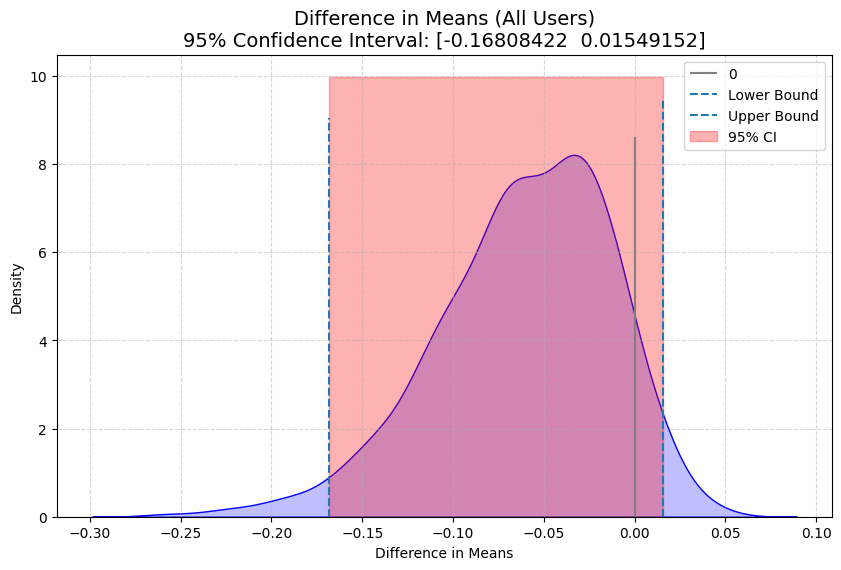

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_bootstrap_all, axis=1),
                                     np.mean(control_bootstrap_all, axis=1),
                                     title='All Users')


What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.


1.	Shapiro-Wilk Test: The data is not normally distributed for both all users and paying users.

2.	Mann-Whitney U Test:
	All users: p-value = 0.478 (no significant difference in revenue between control and variant).
		Paying users: p-value = 0.079 (close to significant but still above 0.05).

3.	Bootstrap Results:
		All users: The 95% confidence interval for the difference in means includes 0, indicating no significant change.
		Paying users: The confidence interval also includes 0, showing no significant impact on revenue.

Conclusion:
All Users: No significant revenue difference between the control and variant groups.

Paying Users: A small hint of difference (p = 0.079), but not statistically significant. Further data might be needed.

The variant does not lead to a significant revenue change for either group, suggesting it may not achieve the desired impact.